### Explore GOBAI-O2 dataset

In [1]:
import xarray as xr
import cftime
import utils.geo as geo
from xhistogram.xarray import histogram
import numpy as np
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
rootdir = '/projects/SOCCOM/datasets/gobai-o2/'
filename = 'GOBAI-O2-v1.0_processed.zarr'
ds = xr.open_zarr(rootdir+filename)
grid = xr.open_dataset(rootdir+'regular_grid.nc')

In [3]:
grid['volcello']=grid['rC']*grid['dp']

In [4]:
oxy_bins = np.linspace(0,400,50)

In [5]:
hs = histogram(ds['oxy'],bins=[oxy_bins],weights=grid['volcello'],dim=['lon','lat','pres'])

In [6]:
with ProgressBar():
    hs = hs.compute()

[########################################] | 100% Completed | 19.55 s


In [27]:
t1 = ['2005','2009']
t2 = ['2015','2019']
t1slice = slice(t1[0]+'-01-01',t1[1]+'-12-31')
t2slice = slice(t2[0]+'-01-01',t2[1]+'-12-31')
t1label = t1[0]+' to '+t1[1]
t2label = t2[0]+' to '+t2[1]
t1color='tab:blue'
t2color='tab:orange'

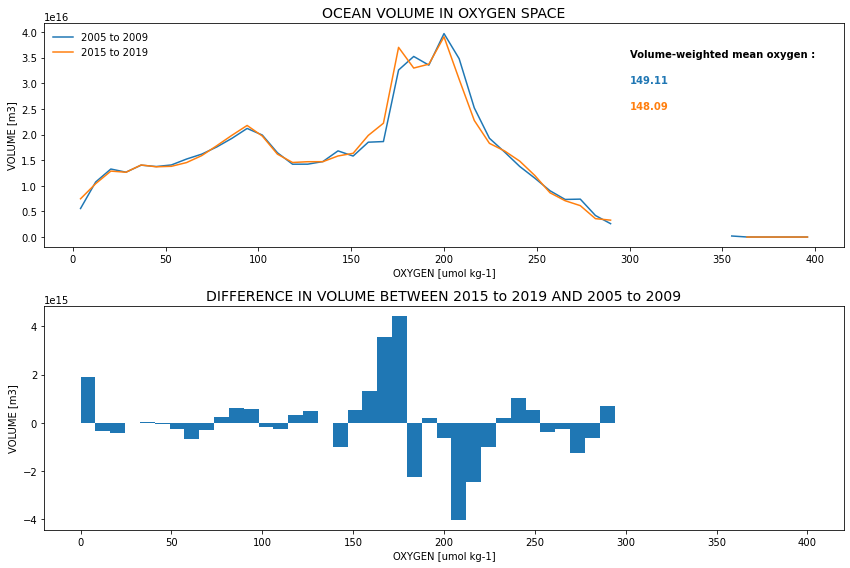

In [28]:
fig,ax = plt.subplots(figsize=(12,8),nrows=2)

# Calculations
hs_t1 = hs.sel(time=t1slice).mean('time')
hs_t2 = hs.sel(time=t2slice).mean('time')
wm_t1 = hs_t1['oxy_bin'].weighted(hs_t1.fillna(0)).mean('oxy_bin')
wm_t2 = hs_t2['oxy_bin'].weighted(hs_t2.fillna(0)).mean('oxy_bin')
hs_diff = hs_t2-hs_t1

# Plot
ax[0].plot(hs_t1['oxy_bin'],hs_t1,label=t1label,color=t1color)
ax[0].plot(hs_t2['oxy_bin'],hs_t2,label=t2label,color=t2color)
ax[0].text(300,3.5e16,'Volume-weighted mean oxygen :',fontweight='bold')
ax[0].text(300,3e16,str(np.round(wm_t1.values,2)),color=t1color,fontweight='bold')
ax[0].text(300,2.5e16,str(np.round(wm_t2.values,2)),color=t2color,fontweight='bold')
ax[0].set_ylabel('VOLUME [m3]')
ax[0].set_xlabel('OXYGEN [umol kg-1]')
ax[0].set_title('OCEAN VOLUME IN OXYGEN SPACE',fontsize=14)
ax[0].legend(loc='upper left',frameon=False)

doxy = hs['oxy_bin'][1]-hs['oxy_bin'][0]
ax[1].bar(hs_diff['oxy_bin'],hs_diff,width=doxy)
ax[1].set_ylabel('VOLUME [m3]')
ax[1].set_xlabel('OXYGEN [umol kg-1]')
ax[1].set_title('DIFFERENCE IN VOLUME BETWEEN '+t2label+' AND '+t1label,fontsize=14)

fig.tight_layout()
fig.savefig('../figures/GOBAI-O2/volume-in-o2.png',dpi=300)